In [1]:
import os
os.chdir('../')

In [2]:
import random

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from src.DRL.qnetwork import QNetwork
from src.XAI.autoencoder import Autoencoder
from src.XAI.concept import Concept
from src.XAI.concept_probes import train_probes
from src.XAI.concepts import concept_instances
from src.XAI.train_probes import get_hyperparams_combinations

In [3]:
layer = 5
env_steps = Concept.load_concept_data()
model_path = QNetwork.find_newest_model()
model_path = "runs/20240317-112025/model_10000000.pt"
model = QNetwork(model_path=model_path)

Loaded model: 20240317-112025-10000000


In [4]:
hyperparam_ranges = {
    'lr': (0.001,),
    'batch_size': (64,),
    'lambda_l1': (0.0,),
    'patience': (5,),
    'epochs': (100,)
}
hyperparams = get_hyperparams_combinations(hyperparam_ranges)

In [5]:
class ModelProbeOptimizer(nn.Module):
    def __init__(self, model, probe, probe_layer):
        super().__init__()
        self.probe = probe
        self.probe_layer = probe_layer

        # Extract the part of the model up to the target layer
        self.model_part = model.network[:probe_layer + 1]

    def forward(self, x):
        # Change to (batch, channel, width, height)
        if x.shape[1] == x.shape[2]:
            x = x.permute(0, 3, 1, 2)
            
        activations = self.model_part(x)

        # Forward pass through the probe model
        probe_output = self.probe(activations)
        return probe_output
    
    def forward_activations(self, x):
        if x.shape[1] == x.shape[2]:
            x = x.permute(0, 3, 1, 2)
            
        activations = self.model_part(x)
        return activations
    
    def forward_probe(self, activations):
        probe_output = self.probe(activations)
        return probe_output

In [6]:
def plot_tensor(tensor):
    input_obs = tensor.clone().detach().numpy().squeeze()
    img = np.stack([input_obs[:, :, 0], input_obs[:, :, 1], input_obs[:, :, 2]], axis=2)
    img /= img.max()
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [7]:
def plot_tensors(tensor1, tensor2):
    # Prepare the original tensor for plotting
    image1 = tensor1.clone().detach().numpy().squeeze()
    image1 = np.stack([image1[:, :, 0], image1[:, :, 1], image1[:, :, 2]], axis=2)
    image1 /= image1.max()
    
    # Prepare the perturbed tensor for plotting
    image2 = tensor2.clone().detach().numpy().squeeze()
    image2 = np.stack([image2[:, :, 0], image2[:, :, 1], image2[:, :, 2]], axis=2)
    image2 /= image2.max()
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    
    axes[0].imshow(image1)
    axes[0].axis('off')
    
    axes[1].imshow(image2)
    axes[1].axis('off')
    
    plt.show()

In [8]:
# Get probe and dataset with a speccific concept
concept = concept_instances['visible lava']
concept.prepare_data(env_steps)
test_obs = torch.tensor(concept.test_obs).float()

load = True
if load:
    probe, score = concept.load_torch_probe()
    print(f"Probe: {probe}, Score: {score}")
else:
    layer_probes, layer_info, best_hyperparams = train_probes(model, concept, hyperparams, [layer])
    probe = layer_probes[layer]
    
optimizer_model = ModelProbeOptimizer(model, probe, layer)

Probe: Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=3136, out_features=1, bias=True)
  (2): Sigmoid()
), Score: 0.769


tensor(0., grad_fn=<MinBackward1>) tensor(1., grad_fn=<MaxBackward1>) tensor(0.6891, grad_fn=<MeanBackward0>) torch.Size([1, 84, 84, 3]) torch.float32
Initial Prediction: 0.0316


/tmp/ipykernel_21316/3176146861.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_obs = torch.tensor(test_obs[example_idx * make_absent]).unsqueeze(0).clone() / 255.0


Final Prediction: 0.9778


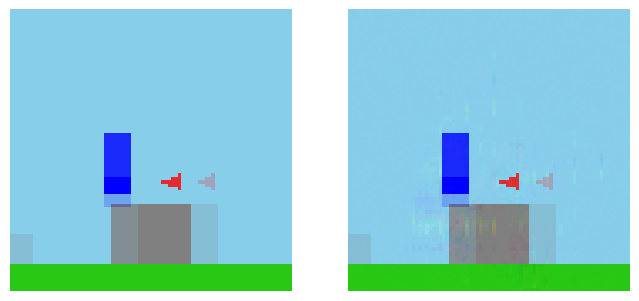

tensor([[0.9778]], grad_fn=<SigmoidBackward0>)


In [9]:
lr = 0.001
iterations = 100
make_absent = -1 # 1 to make concept present, -1 to make the concept absent
example_idx = 1

#input_obs = torch.FloatTensor(train_obs.shape[1:]).uniform_(0, 1).unsqueeze(0).requires_grad_(True)
input_obs = torch.tensor(test_obs[example_idx * make_absent]).unsqueeze(0).clone() / 255.0
original_input_obs = input_obs.clone()
input_obs.requires_grad_(True)
print(input_obs.min(), input_obs.max(), input_obs.mean(), input_obs.shape, input_obs.dtype)
print(f"Initial Prediction: {optimizer_model(input_obs).item():.4f}")
optimizer = torch.optim.Adam([input_obs], lr=lr)

for i in range(iterations):
    optimizer.zero_grad()
    
    prediction = optimizer_model(input_obs)
    loss = prediction * make_absent
    loss = loss + torch.mean(torch.abs(input_obs - original_input_obs)) * 100

    loss.backward()
    optimizer.step()
    
    input_obs.data = input_obs.data.clamp(0, 1)
    
input_obs.data = input_obs.data.clamp(0, 1)
final_prediction = optimizer_model(input_obs)
print(f"Final Prediction: {final_prediction.item():.4f}")
plot_tensors(original_input_obs, input_obs)
_, acts_dict = model(input_obs * 255.0, return_acts=True)
acts = acts_dict[layer]
print(probe(acts))

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_concept = concept_instances['random continuous']
train_concept.prepare_data(env_steps)
autoencoder = Autoencoder(latent_dim=32, train_obs=torch.tensor(train_concept.train_obs).float(), test_obs=torch.tensor(train_concept.test_obs).float(), device=device)
autoencoder.train_model(num_epochs=100, batch_size=64, learning_rate=0.001)

Epoch 0/100 | Train Loss: 8.314865779876708 | Val Loss: 3.363935935974121
Epoch 1/100 | Train Loss: 2.9178509607315064 | Val Loss: 2.6708812698364257
Epoch 2/100 | Train Loss: 2.402124416923523 | Val Loss: 2.185528402709961
Epoch 3/100 | Train Loss: 2.080134420967102 | Val Loss: 1.9299442596435548
Epoch 4/100 | Train Loss: 1.8521075277328491 | Val Loss: 1.7413957153320312
Epoch 5/100 | Train Loss: 1.6707590236663818 | Val Loss: 1.604791485595703
Epoch 6/100 | Train Loss: 1.5509149438858032 | Val Loss: 1.4976026458740235
Epoch 7/100 | Train Loss: 1.458136032485962 | Val Loss: 1.4328617462158204
Epoch 8/100 | Train Loss: 1.3839597303390503 | Val Loss: 1.3510727905273439
Epoch 9/100 | Train Loss: 1.3107121317863464 | Val Loss: 1.297616891479492
Epoch 10/100 | Train Loss: 1.2561615717887877 | Val Loss: 1.2598867370605469
Epoch 11/100 | Train Loss: 1.211535895061493 | Val Loss: 1.2100662422180175
Epoch 12/100 | Train Loss: 1.1618869973182677 | Val Loss: 1.171856757736206
Epoch 13/100 | Trai

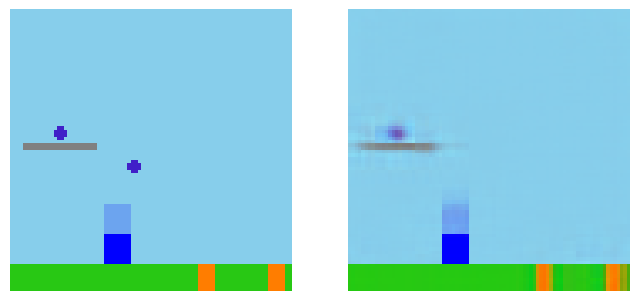

In [11]:
image = test_obs[random.randint(0,len(test_obs))].unsqueeze(0).to(device)
reconstructed_image = autoencoder(image)
plot_tensors(image.cpu(), reconstructed_image.cpu())

### Concept backprop with decoder

/tmp/ipykernel_21316/3777700400.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_obs = torch.tensor(test_obs[example_idx]).unsqueeze(0)


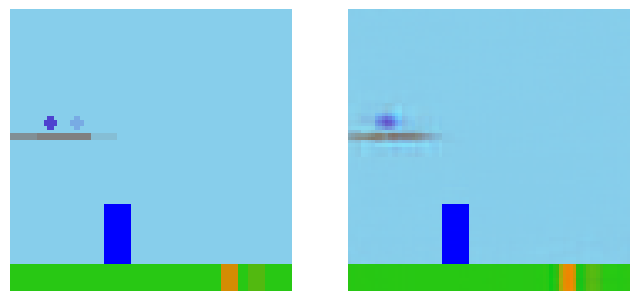

Initial Prediction: tensor([[0.9869]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Final Prediction: tensor([[0.9869]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Final Prediction: tensor([[0.9869]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Final Prediction: tensor([[0.9869]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Final Prediction: tensor([[0.9869]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Final Prediction: tensor([[0.9869]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Final Prediction: tensor([[0.9869]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Final Prediction: tensor([[0.9869]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Final Prediction: tensor([[0.9866]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Final Prediction: tensor([[0.9847]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Final Prediction: tensor([[0.0808]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Final Prediction: tensor([[0.0600]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Final Predicti

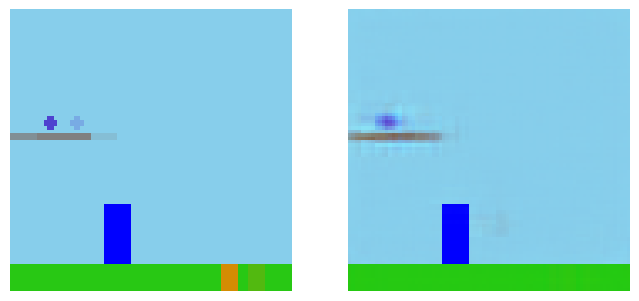

In [13]:
# Initialize model and device
optimizer_model.to(device)
iterations = 1000
loss_ratio = 1
target_concept_value = 0
example_idx = 1
tolerance = 0.05

# Prepare input observation
input_obs = torch.tensor(test_obs[example_idx]).unsqueeze(0)
input_obs = input_obs.to(device)
input_obs_activations = autoencoder.encoder(input_obs).to(device)

# Initialize perturbation
perturbation = torch.zeros_like(input_obs_activations, requires_grad=True).to(device)
decoded = autoencoder.decoder(input_obs_activations + perturbation) / 255.0
plot_tensors(input_obs.cpu(), decoded.cpu())
initial_prediction = optimizer_model.forward(decoded)
print(f"Initial Prediction: {initial_prediction}")

successful = False
start_learning_rate = 0.01
best_loss = float('inf')
stagnant_steps = 0

while not successful and loss_ratio < 10000000:
    learning_rate = start_learning_rate
    while True:
        decoded = autoencoder.decoder(input_obs_activations + perturbation) / 255.0
        concept_value_pred = optimizer_model.forward(decoded)
        loss1 = torch.norm(concept_value_pred - target_concept_value, p=2)
        loss2 = torch.norm(perturbation, p=2)
        #loss2 = torch.norm(decoded - input_obs, p=2)
        total_loss = loss_ratio * loss1 + loss2
        # print(f"Iteration {i:3d} - Loss1: {loss1:.4f}, Loss2: {loss2:.4f}, Total Loss: {total_loss:.4f}")

        if total_loss < best_loss:
            best_loss = total_loss
            stagnant_steps = 0
        else:
            stagnant_steps += 1

        if stagnant_steps >= 5:
            learning_rate /= 2
            stagnant_steps = 0
            if learning_rate < 0.000001:
                break

        total_loss.backward(retain_graph=True)

        # Update perturbation
        with torch.no_grad():
            perturbation -= learning_rate * perturbation.grad
            perturbation.grad.zero_()

    final_prediction = optimizer_model.forward(decoded)
    print(f"Final Prediction: {final_prediction}")
    #plot_tensors(input_obs.cpu(), decoded.cpu())

    if abs(final_prediction - target_concept_value) <= tolerance:
        successful = True
        print(f"Successful at Loss Ratio: {loss_ratio}")
        plot_tensors(input_obs.cpu(), decoded.cpu())
    else:
        loss_ratio *= 2

if not successful:
    print("Failed to reach target concept value.")